# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [1]:
%load_ext autoreload
%autoreload 2

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [4]:
import numpy as np

# # 1 Способ
# import keras
# from keras.datasets import fashion_mnist
# (x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
from sklearn.datasets import fetch_openml
def load_fashion_mnist():
    X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
    X = X.reshape(-1, 28, 28).astype('uint8')
    y = y.astype('int64')
    x_train, x_test = X[:60000], X[60000:]
    y_train, y_test = y[:60000], y[60000:]
    return (x_train, y_train), (x_test, y_test)
(x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент?

**Ответ:** цель pca понизить размерность, в нашей задаче svm мы будем создавать новые размерности признаков, на основе имеющихся, значит будут еще более высокие размерности. для эффективности работы ядрового svmа, понизим размерность на изначальных данных, а потом увеличим размерность при использовании алгоритма, тем самым избежав слишком высоких размерностей.

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [5]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator
from sklearn.metrics import accuracy_score, classification_report

pipeline = RFFPipeline(n_features=1000, new_dim=50, classifier = 'svm_linear', feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n accuracy svm: {accuracy:.4f}")

print(classification_report(y_test, y_pred))


 accuracy svm: 0.8749
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.78      0.78      0.78      1000
           3       0.88      0.90      0.89      1000
           4       0.79      0.82      0.80      1000
           5       0.97      0.94      0.95      1000
           6       0.70      0.65      0.67      1000
           7       0.92      0.96      0.94      1000
           8       0.97      0.95      0.96      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [12]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator
from sklearn.metrics import accuracy_score, classification_report

pipeline = RFFPipeline(n_features=1000, new_dim=50, classifier = 'logreg', feature_creator_class=RandomFeatureCreator, classifier_params = {'max_iter': 2000})
pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n accuracy log reg: {accuracy:.4f}")

print(classification_report(y_test, y_pred))


 accuracy log reg: 0.8759
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.78      0.79      1000
           3       0.88      0.90      0.89      1000
           4       0.78      0.81      0.80      1000
           5       0.97      0.94      0.96      1000
           6       0.69      0.65      0.67      1000
           7       0.92      0.96      0.94      1000
           8       0.97      0.96      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [8]:
import time
from sklearn.metrics import accuracy_score, f1_score
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator, FeatureCreatorPlaceholder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from catboost import CatBoostClassifier

def compare_models_simple(X_train, y_train, X_test, y_test):
    results = {}

    start = time.time()
    rff_svm_linear = RFFPipeline(
        n_features=1000,
        new_dim=50,
        use_PCA=True,
        feature_creator_class=RandomFeatureCreator,
        classifier='svm_linear'
    )

    rff_svm_linear.fit(X_train, y_train)
    rff_svm_linear_train_time = time.time() - start
    y_pred_rff_svm_linear = rff_svm_linear.predict(X_test)
    rff_svm_linear_accuracy = accuracy_score(y_test, y_pred_rff_svm_linear)

    print(f"Accuracy: {rff_svm_linear_accuracy:.4f}")
    print(f"Training time: {rff_svm_linear_train_time:.2f}s")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    start = time.time()
    svm_linear_orig = SVC(kernel='linear')
    svm_linear_orig.fit(X_train_scaled, y_train)
    svm_linear_orig_train_time = time.time() - start

    y_pred_svm_linear_orig = svm_linear_orig.predict(X_test)
    svm_linear_orig_accuracy = accuracy_score(y_test, y_pred_svm_linear_orig)
    print(f"Accuracy: {svm_linear_orig_accuracy:.4f}")
    print(f"Training time: {svm_linear_orig_train_time:.2f}s")

    start = time.time()
    svm_rbf = SVC(kernel='rbf')
    svm_rbf.fit(X_train_scaled, y_train)
    svm_rbf_train_time = time.time() - start
    y_pred_svm_rbf = svm_rbf.predict(X_test)
    svm_rbf_accuracy = accuracy_score(y_test, y_pred_svm_rbf)
    print(f"Accuracy: {svm_rbf_accuracy:.4f}")
    print(f"Training time: {svm_rbf_train_time:.2f}s")

    start = time.time()
    pca_catboost = RFFPipeline(
        n_features=0,
        new_dim=50,
        use_PCA=True,
        feature_creator_class=FeatureCreatorPlaceholder,
        classifier='catboost',
        classifier_params={'iterations': 100}
    )
    pca_catboost.fit(X_train, y_train)
    pca_catboost_train_time = time.time() - start
    y_pred_pca_catboost = pca_catboost.predict(X_test)
    pca_catboost_accuracy = accuracy_score(y_test, y_pred_pca_catboost)
    print(f"Accuracy: {pca_catboost_accuracy:.4f}")
    print(f"Training time: {pca_catboost_train_time:.2f}s")

    start = time.time()
    ordinary_catboost = CatBoostClassifier(
        iterations=100,
        verbose=False
    )
    ordinary_catboost.fit(X_train, y_train)
    ordinary_catboost_train_time = time.time() - start
    y_pred_ordinary_catboost = ordinary_catboost.predict(X_test)
    ordinary_catboost_accuracy = accuracy_score(y_test, y_pred_ordinary_catboost)
    print(f"Accuracy: {ordinary_catboost_accuracy:.4f}")
    print(f"Training time: {ordinary_catboost_train_time:.2f}s")

    results = {
        'rff_svm_linear': {
            'accuracy': rff_svm_linear_accuracy,
            'train_time': rff_svm_linear_train_time,
        },
        'svm_linear_orig': {
            'accuracy': svm_linear_orig_accuracy,
            'train_time': svm_linear_orig_train_time,
        },
        'svm_rbf': {
            'accuracy': svm_rbf_accuracy,
            'train_time': svm_rbf_train_time,
        },
        'pca_catboost': {
            'accuracy': pca_catboost_accuracy,
            'train_time': pca_catboost_train_time,
        },
        'ordinary_catboost': {
            'accuracy': ordinary_catboost_accuracy,
            'train_time': ordinary_catboost_train_time,
        }
    }
    return results

In [9]:
results = compare_models_simple(x_train, y_train, x_test, y_test)

Accuracy: 0.8765
Training time: 1365.77s
Accuracy: 0.7333
Training time: 611.65s
Accuracy: 0.1000
Training time: 278.47s
Accuracy: 0.8521
Training time: 5.02s
Accuracy: 0.8600
Training time: 89.02s


__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [10]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator, FeatureCreatorPlaceholder
import time
from sklearn.metrics import accuracy_score, f1_score

def experiment_pca_simple(X_train, y_train, X_test, y_test, n_features=1000, pca_dim=50):
    results = []

    start = time.time()
    model_no_pca = RFFPipeline(
        n_features=n_features,
        new_dim=X_train.shape[1],
        use_PCA=False,
        feature_creator_class=RandomFeatureCreator,
        classifier='svm_linear'
    )

    model_no_pca.fit(X_train, y_train)
    time_no_pca = time.time() - start

    y_pred_no_pca = model_no_pca.predict(X_test)
    accuracy_no_pca = accuracy_score(y_test, y_pred_no_pca)
    print(f"Без PCA: Accuracy={accuracy_no_pca:.4f}, Time={time_no_pca:.2f}s")

    start = time.time()
    model_pca = RFFPipeline(
        n_features=n_features,
        new_dim=pca_dim,
        use_PCA=True,
        feature_creator_class=RandomFeatureCreator,
        classifier='svm_linear'
    )
    model_pca.fit(X_train, y_train)
    time_pca = time.time() - start

    y_pred_pca = model_pca.predict(X_test)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)

    print(f"С PCA: Accuracy={accuracy_pca:.4f}, Time={time_pca:.2f}s")

    return {
        'no_pca': {'accuracy': accuracy_no_pca, 'time': time_no_pca},
        'with_pca': {'accuracy': accuracy_pca, 'time': time_pca}
    }

In [11]:
results = experiment_pca_simple(x_train, y_train, x_test, y_test)

Без PCA: Accuracy=0.8582, Time=4274.06s
С PCA: Accuracy=0.8785, Time=1363.22s


Мы получили ускорение обучения и лучшую точность, супер тема

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator, FeatureCreatorPlaceholder

def experiment_n_features(X_train, y_train, X_test, y_test,
                         n_features_list=None, use_PCA=True, pca_dim=50):
    if n_features_list is None:
        n_features_list = [55, 100, 500, 700, 1000, 2000, 3000, 4000, 6000]

    results = []

    for n_features in n_features_list:
        print(f"Тестируем n_features = {n_features} ===")


        model = RFFPipeline(
            n_features=n_features,
            new_dim=pca_dim,
            use_PCA=use_PCA,
            feature_creator_class=RandomFeatureCreator,
            classifier='svm_linear'
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            'n_features': n_features,
            'accuracy': accuracy,
            'f1': f1
        })

        print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

    return results

def plot_n_features_results(results):
    n_features = [r['n_features'] for r in results]
    accuracy = [r['accuracy'] for r in results]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(n_features, accuracy, 'bo-', linewidth=2, markersize=6)
    ax1.set_xlabel('Количество признаков')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Зависимость качества от количества признаков')
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return fig

In [ ]:
n_features_results = experiment_n_features(x_train, y_train, x_test, y_test)
plot_n_features_results(n_features_results)

Тестируем n_features = 55 ===
Accuracy: 0.8258, F1: 0.8237
Тестируем n_features = 100 ===
Accuracy: 0.8477, F1: 0.8467
Тестируем n_features = 500 ===
Accuracy: 0.8734, F1: 0.8733
Тестируем n_features = 700 ===
Accuracy: 0.8760, F1: 0.8757
Тестируем n_features = 1000 ===
Accuracy: 0.8781, F1: 0.8779
Тестируем n_features = 2000 ===
Accuracy: 0.8790, F1: 0.8786
Тестируем n_features = 3000 ===
Accuracy: 0.8797, F1: 0.8794
Тестируем n_features = 4000 ===
Accuracy: 0.8800, F1: 0.8798
Тестируем n_features = 6000 ===


(0.82, 0.885)

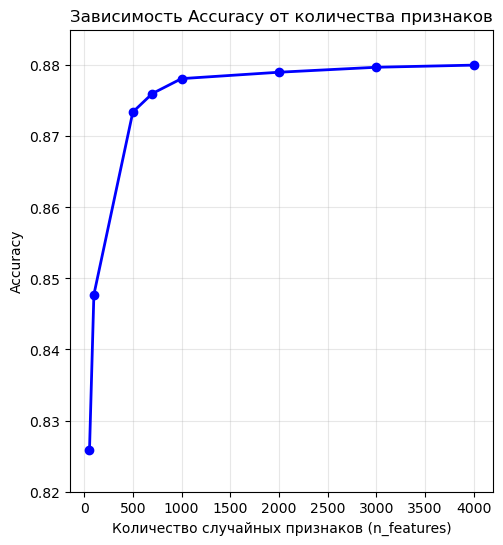

In [5]:
import matplotlib.pyplot as plt
n_features = [55, 100, 500, 700, 1000, 2000, 3000, 4000]
accuracy = [0.8258, 0.8477, 0.8734, 0.8760, 0.8781, 0.8790, 0.8797, 0.8800]
f1_scores = [0.8237, 0.8467, 0.8733, 0.8757, 0.8779, 0.8786, 0.8794, 0.8798]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(n_features, accuracy, 'bo-', linewidth=2, markersize=6, label='Accuracy')
plt.xlabel('Количество случайных признаков (n_features)')
plt.ylabel('Accuracy')
plt.title('Зависимость Accuracy от количества признаков')
plt.grid(True, alpha=0.3)
plt.ylim(0.82, 0.885)

Ожидаемое плато при >700 признаках

In [12]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator
import time
from sklearn.metrics import accuracy_score, f1_score

def compare_classifiers(X_train, y_train, X_test, y_test, n_features=1000):
    results = {}
    
    start = time.time()
    model_lr = RFFPipeline(
        n_features=n_features, new_dim=50, use_PCA=True,
        feature_creator_class=RandomFeatureCreator, classifier='logreg', classifier_params = {'max_iter': 2000}
    )
    model_lr.fit(X_train, y_train)
    time_lr = time.time() - start
    y_pred_lr = model_lr.predict(X_test)
    
    start = time.time()
    model_svm = RFFPipeline(
        n_features=n_features, new_dim=50, use_PCA=True,
        feature_creator_class=RandomFeatureCreator, classifier='svm_linear'
    )
    model_svm.fit(X_train, y_train)
    time_svm = time.time() - start
    y_pred_svm = model_svm.predict(X_test)
    
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    
    print(f"Logistic Regression: Accuracy={accuracy_lr:.4f}, Time={time_lr:.2f}s")
    print(f"SVM Linear: Accuracy={accuracy_svm:.4f}, Time={time_svm:.2f}s")

    return {
        'logreg': {'accuracy': accuracy_lr, 'time': time_lr},
        'svm': {'accuracy': accuracy_svm, 'time': time_svm}
    }

In [13]:
results = compare_classifiers(x_train, y_train, x_test, y_test, n_features=1000)

Logistic Regression: Accuracy=0.8741, Time=158.43s
SVM Linear: Accuracy=0.8764, Time=23601.30s


Не сильно важно какой классификатор, если категорично оценивать, то конечно svm может выигрывать, особенно если rbf ядро, но очень страдает скорость обучения, буквально на 300%

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.


In [14]:
import time
from sklearn.metrics import accuracy_score
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator, OrthogonalRandomFeatureCreator

def simple_experiments(X_train, y_train, X_test, y_test):
    results = []
    
    print("=== 1. Обычный RFF ===")
    start = time.time()
    model1 = RFFPipeline(
        n_features=750, new_dim=50, use_PCA=True,
        feature_creator_class=RandomFeatureCreator,
        classifier='svm_linear'
    )
    model1.fit(X_train, y_train)
    time1 = time.time() - start
    acc1 = accuracy_score(y_test, model1.predict(X_test))
    print(f"Accuracy: {acc1:.4f}, Time: {time1:.2f}s")
    results.append(('RFF (1000>50)', acc1, time1))
    
    print("=== 2. ORF (n_features > new_dim) ===")
    start = time.time()
    model2 = RFFPipeline(
        n_features=750, new_dim=50, use_PCA=True,
        feature_creator_class=OrthogonalRandomFeatureCreator,
        classifier='svm_linear'
    )
    model2.fit(X_train, y_train)
    time2 = time.time() - start
    acc2 = accuracy_score(y_test, model2.predict(X_test))
    print(f"Accuracy: {acc2:.4f}, Time: {time2:.2f}s")
    results.append(('ORF (750>50)', acc2, time2))
    
    print("=== 3. ORF (n_features = new_dim) ===")
    start = time.time()
    model3 = RFFPipeline(
        n_features=50, new_dim=50, use_PCA=True,
        feature_creator_class=OrthogonalRandomFeatureCreator,
        classifier='svm_linear'
    )
    model3.fit(X_train, y_train)
    time3 = time.time() - start
    acc3 = accuracy_score(y_test, model3.predict(X_test))
    print(f"Accuracy: {acc3:.4f}, Time: {time3:.2f}s")
    results.append(('ORF (50=50)', acc3, time3))
    
    print("=== 4. ORF (n_features < new_dim) ===")
    start = time.time()
    model4 = RFFPipeline(
        n_features=30, new_dim=50, use_PCA=True,
        feature_creator_class=OrthogonalRandomFeatureCreator,
        classifier='svm_linear'
    )
    model4.fit(X_train, y_train)
    time4 = time.time() - start
    acc4 = accuracy_score(y_test, model4.predict(X_test))
    print(f"Accuracy: {acc4:.4f}, Time: {time4:.2f}s")
    results.append(('ORF (30<50)', acc4, time4))
    
    return results

In [15]:
results = simple_experiments(x_train, y_train, x_test, y_test)

=== 1. Обычный RFF ===
Accuracy: 0.8753, Time: 30540.11s
=== 2. ORF (n_features > new_dim) ===
Accuracy: 0.8785, Time: 14080.28s
=== 3. ORF (n_features = new_dim) ===
Accuracy: 0.8280, Time: 82.50s
=== 4. ORF (n_features < new_dim) ===
Accuracy: 0.8014, Time: 61.40s


Ну че тут сказать)) все очев 

ORF особо не дал результата, что жаль

Признаки очень важны, время выполнения в более чем квадратичной зависимости


__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___

___описание идеи:___

In [ ]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator, OrthogonalRandomFeatureCreator, LaplacianRFF
import time
from sklearn.metrics import accuracy_score

def Laplacian_comp(X_train, y_train, X_test, y_test):
    results = []
    
    start = time.time()
    rff_model = RFFPipeline(
        n_features=750, new_dim=50, use_PCA=True,
        feature_creator_class=RandomFeatureCreator,
        classifier='svm_linear'
    )
    
    rff_model.fit(X_train, y_train)
    time1 = time.time() - start
    acc1 = accuracy_score(y_test, rff_model.predict(X_test))
    print(f"Accuracy RFF default, use_PCA: {acc1:.4f}, Time: {time1:.2f}s")
    results.append(('RFF default, use_PCA', acc1, time1))

    start = time.time()
    orf_model = RFFPipeline(
        n_features=750, new_dim=50, use_PCA=True,
        feature_creator_class=OrthogonalRandomFeatureCreator,
        classifier='svm_linear'
    )
    
    orf_model.fit(X_train, y_train)
    time2 = time.time() - start
    acc2 = accuracy_score(y_test, orf_model.predict(X_test))
    print(f"Accuracy ORF, 750 feat, use_PCA: {acc2:.4f}, Time: {time2:.2f}s")
    results.append(('ORF, 750 feat, use_PCA', acc2, time2))


    start = time.time()
    laplacian_model = RFFPipeline(
        n_features=750, new_dim=50, use_PCA=True,
        feature_creator_class=LaplacianRFF,
        classifier='svm_linear'
    )
    laplacian_model.fit(X_train, y_train)
    time3 = time.time() - start
    acc3 = accuracy_score(y_test, laplacian_model.predict(X_test))
    print(f"Accuracy laplacian_model, 750 feat, use_PCA: {acc3:.4f}, Time: {time3:.2f}s")
    results.append(('laplacian_model, 750 feat, use_PCA', acc3, time3))
    return results

In [ ]:
results = Laplacian_comp(x_train, y_train, x_test, y_test)

Accuracy RFF default, use_PCA: 0.8766, Time: 1084.61s
Accuracy ORF, 750 feat, use_PCA: 0.8762, Time: 1028.58s
Accuracy laplacian_model, 750 feat, use_PCA: 0.8576, Time: 2363.39s


__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**.
Подумайте о том, как в формулах правильно учесть свободный коэффициент.

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___
$$
Q(w) = \frac{1}{2} \| \Phi \Phi^T w - y \|^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w$$

$$K = \Phi \Phi^T$$

$$Q(w) = \frac{1}{2} \| K w - y \|^2 + \frac{\lambda}{2} w^T K w$$

$$\nabla f_1(w) = K (K w - y)$$

$$\nabla f_2(w) = \lambda K w$$

$$\nabla Q(w) = K (K w - y) + \lambda K w$$

$$\nabla Q(w) = K ((K + \lambda I) w - y)$$

$$\boxed{\nabla Q(w) = K((K + \lambda I)w - y)}$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

KernelRidge - MSE: 0.3516
RFF - MSE: 1.2108


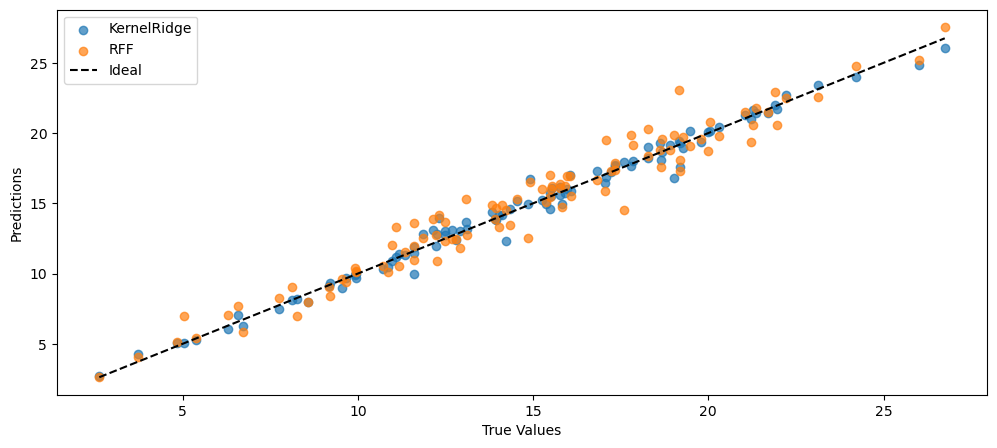

In [20]:
from homework_practice_08_kernel_regression import KernelRidgeRegression,RFFRegression
from homework_practice_08_rff import RandomFeatureCreator
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1, make_regression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X, y = make_friedman1(n_samples=300, n_features=5, noise=0.1, random_state=42)

split = 200
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

krr = KernelRidgeRegression(regularization=0.01, kernel_scale=2.0)
krr.fit_closed_form(X_train_scaled, y_train)
y_pred_krr = krr.predict(X_test_scaled)

rff = RFFRegression(
    n_features=1000,  
    new_dim=4,      
    use_PCA=True,   
    feature_creator_class=RandomFeatureCreator,
    regressor='ridge'
)
rff.fit(X_train_scaled, y_train)
y_pred_rff = rff.predict(X_test_scaled)


print("KernelRidge - MSE: {:.4f}".format(mean_squared_error(y_test, y_pred_krr)))
print("RFF - MSE: {:.4f}".format(mean_squared_error(y_test, y_pred_rff)))

plt.figure(figsize=(12, 5))
plt.scatter(y_test, y_pred_krr, alpha=0.7, label='KernelRidge')
plt.scatter(y_test, y_pred_rff, alpha=0.7, label='RFF')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()